### This is to study the relationship between phase in oscilation and performance


先经过100ms的pre-stimulaiton时间来让震荡稳定下来  
然后根据希尔伯特变换找到100ms后的第一个相位最低点的位置（-pi）  
从这个位置开始刺激10ms+测试  
全程1000ms  

In [2]:
# import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import hilbert

from functions import Generate_Vectors, Generate_RandomMatrix
from functions import show_mn, show_conn
from functions import Draw_Output, Draw_Conductance,  load_config_yaml, Draw_RasterPlot, Draw_Voltage, Draw_Projection, save_model
from functions import plot_peak_envelope, peak_envelope
from functions import load_init
from lowranksnn import LowRankSNN
plt.rcParams.update({'font.size': 30})  

from pathlib import Path
import os
import csv
import datetime
import yaml



In [3]:
# Read the configuration file
config = load_config_yaml('./configures/config_test_phase_sensitivity.yaml')
# config = load_config_yaml('confi_gamma_os_bias_only.yaml')
# config = load_config_yaml('config_test.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']

eta_E = config['eta_E']
eta_I = config['eta_I']
delta_E = config['delta_E']
delta_I = config['delta_I']

mu = config['mu']
si = config['sigma']

si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']

num_phase = config['num_phase']
trails = config['trails']


In [4]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)
# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector
# m, n, Sti_nogo = Generate_Vectors(N, mu, si)
i = 0
while i<100:
    m_test, n_test, Sti_nogo_test = Generate_Vectors(N, mu, si)
    if torch.sum(m_test[:N_E]).abs() < 1 and torch.sum(n_test[:N_E]).abs() < 1 and torch.sum(Sti_nogo_test[:N_E]).abs() < 1:
        print(N,mu,si)
        # sum of all the element in m and n and Sti_nogo_test
        print(torch.sum(m_test[:N_E]))
        print(torch.sum(n_test[:N_E]))
        print(torch.sum(Sti_nogo_test[:N_E]))
        print('i:',i)
        print('-----------------------------------')
        m = m_test
        n = n_test
        Sti_nogo = Sti_nogo_test
        break
    i += 1
    if i == 100:
        i = 0
        print('did not find the suitable m, n, Sti_nogo')

m[N_E:] = 0
n[N_E:] = 0
Sti_nogo[N_E:] = 0
Sti_go = n.clone()
W_out = m.clone()
W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)


did not find the suitable m, n, Sti_nogo
did not find the suitable m, n, Sti_nogo
1000 0 0.2
tensor(0.6616)
tensor(0.5938)
tensor(0.1002)
i: 84
-----------------------------------


In [5]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# # count the number of values outside the range of 0 and 1
# print('Number of values outside the range of 0 and 1: ', torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))
# # ratio of values outside the range of 0 and 1 to the total number of values
# print('Ratio of values outside the range of 0 and 1 to the total number of values: ', (torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))/(N_E+N_I)**2)
LRSNN.conn[LRSNN.conn>1] = 1
LRSNN.conn[LRSNN.conn<0] = 0

Low Rank connection and readout vector have been added.
Random connection has been added.


In [6]:
# 1st simulation: get the first zero phase time after 100 ms (use hilbert transform)

T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo
#

# bias current
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
# Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go = LRSNN(dt,bias)
# Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo+bias)
# _, _, g_ref, _, _, _ = LRSNN(dt,bias)
Out_ref, V_ref, [g_ref,g_ref_EE,g_ref_EI,g_ref_IE,g_ref_II],[I_ref_syn,I_ref_syn_EE,I_ref_syn_EI,I_ref_syn_IE,I_ref_syn_II], spk_step_ref, spk_ind_ref, spk_ref, phase_ref = LRSNN(dt,bias)
# Out_ref, V_ref, [g_ref,g_ref_EE,g_ref_EI,g_ref_IE,g_ref_II],[I_ref_syn,I_ref_syn_EE,I_ref_syn_EI,I_ref_syn_IE,I_ref_syn_II], spk_step_ref, spk_ind_ref, spk_ref, phase_ref = LRSNN(dt,Input_go+bias)

# g_ref_EE = g_ref[1]
# g_ref_II = g_ref[-1]


Start Simulation
Simulation Finished


In [7]:
# load the values at T_pre

LRSNN = load_init(LRSNN, T_pre, dt, g_ref, g_ref_EE, g_ref_EI, g_ref_IE, g_ref_II, V_ref, phase_ref, I_ref_syn, I_ref_syn_EE, I_ref_syn_EI, I_ref_syn_IE, I_ref_syn_II, spk_ref)

# Out, V, [g,g_EE,g_EI,g_IE,g_II],[I_syn,I_syn_EE,I_syn_EI,I_syn_IE,I_syn_II], spk_step, spk_ind, spk, phase = LRSNN(dt,bias[:,int(T_pre/dt):])


Initial values have been loaded.


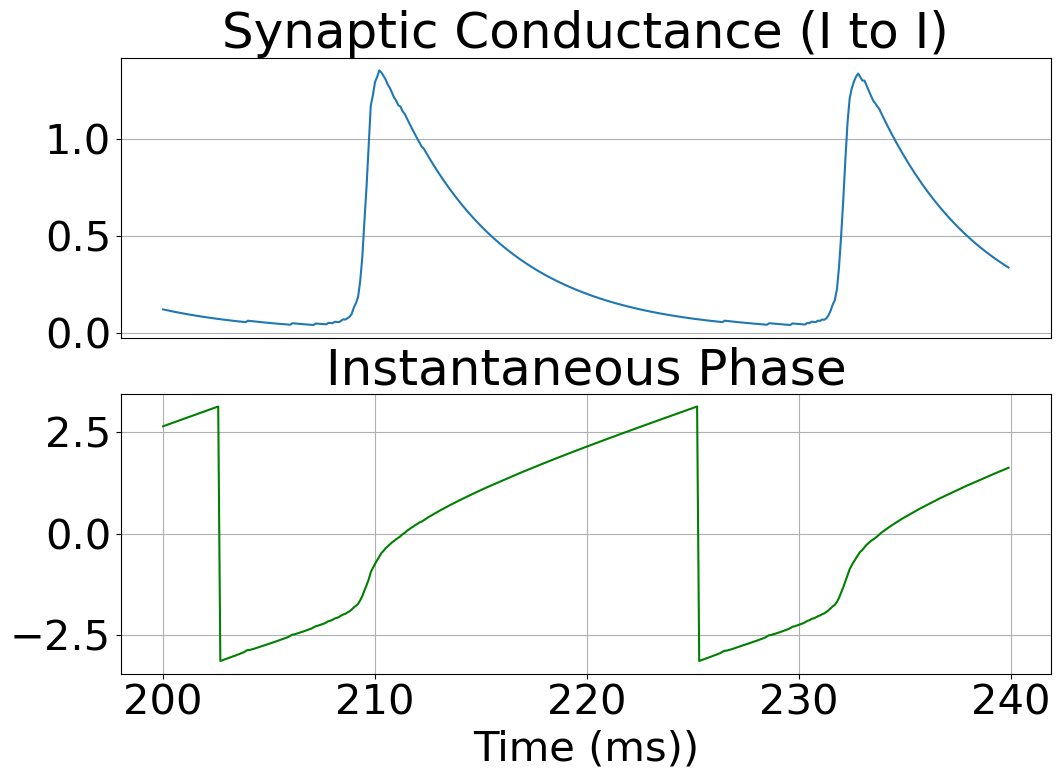

In [9]:

# do hilbert transform to get the phase of the conductance
g_ref_EE_np = g_ref_EE.clone().cpu().detach().numpy()
g_ref_II_np = g_ref_II.clone().cpu().detach().numpy()

# signal = np.mean(g_ref_II_np, axis=0)[int(T_pre/dt):]
# signal = np.mean(g_ref_II_np, axis=0)[int((T_pre-50)/dt):]
signal = np.mean(g_ref_II_np, axis=0) # 从0ms开始，结果应该会更稳定
signal_EE = np.mean(g_ref_EE_np, axis=0)
# # filter out the high frequency noise in the signal
# from scipy.signal import butter, lfilter
# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = lfilter(b, a, data)
#     return y
# signal = butter_lowpass_filter(signal, 100, 1000/dt, order=5) # cutoff frequency higher than 100 Hz

# centralize the signal
mean_signal = np.mean(signal)
signal = signal - mean_signal
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)  # 振幅包络
instantaneous_phase = np.angle(analytic_signal)  # 相位信息
phase_diff = np.diff(instantaneous_phase)  # 相位的一阶导数，即相位变化率
t = np.array(range(len(signal)))*dt
# 绘制波形及其相位信息
# start_time = phase_start_ind*dt
# end_time = phase_end_ind*dt
start_time = T_pre
end_time = T_pre+40
plt.figure(figsize=(12, 8))
t = np.array(range(len(signal)))*dt
# 原始信号
# plt.subplot(3, 1, 1)
plt.subplot(2, 1, 1)
# plt.figure(figsize=(12, 8))
plt.plot(t[int(start_time/dt):int(end_time/dt)], signal[int(start_time/dt):int(end_time/dt)]+mean_signal)
plt.title("Synaptic Conductance (I to I)")
plt.xticks([])
# plt.yticks([])
plt.grid(True)
# plt.xlabel("Time [ms]")
# plt.ylabel("Amplitude")
# plt.legend()


# # 振幅包络
# plt.subplot(3, 1, 2)
# plt.plot(t, amplitude_envelope, color='orange')
# plt.title("Amplitude Envelope (Magnitude of Analytic Signal)")

# 相位信息
# plt.subplot(3, 1, 3)
plt.subplot(2, 1, 2)
# plt.figure(figsize=(12, 8))
# plt.plot(t, instantaneous_phase, color='green')
plt.plot(t[int(start_time/dt):int(end_time/dt)], instantaneous_phase[int(start_time/dt):int(end_time/dt)], color='green')
plt.grid(True)
plt.title("Instantaneous Phase")
plt.xlabel("Time (ms))")
# plt.ylabel("Phase [radians]")
# plt.legend()
ticks = [-np.pi,  0,  np.pi]
labels = [r"$-\pi$",  r"$0$",  r"$\pi$"]

# plt.yticks(ticks, labels)

# plt.tight_layout()
# plt.grid(True)
# plt.show()

# # SYnaptic conductance of E to E
# plt.subplot(3, 1, 2)
# plt.plot(t[int(start_time/dt):int(end_time/dt)], signal_EE[int(start_time/dt):int(end_time/dt)])
# plt.title("Synaptic Conductance (E to E)")
# plt.xticks([])
# # plt.yticks([])
# plt.grid(True)


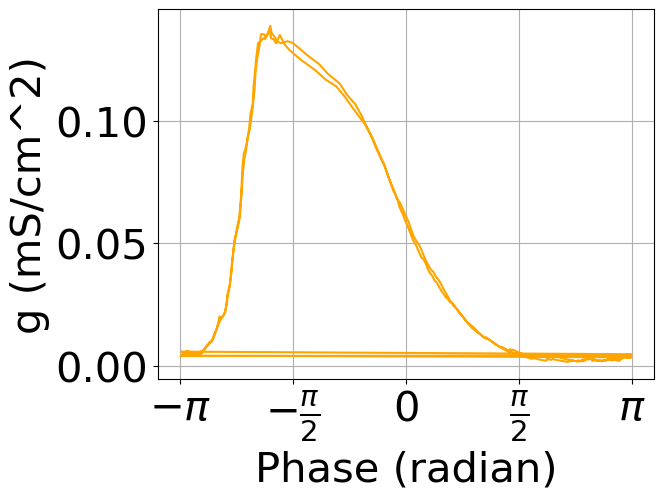

In [35]:
# plt.plot(instantaneous_phase[int(200/dt):int(250/dt)],signal[int(200/dt):int(250/dt)]+mean_signal, color='green')
plt.plot(instantaneous_phase[int(200/dt):int(250/dt)],signal_EE[int(200/dt):int(250/dt)], color='orange')
# plt.title("Synaptic Conductance (I to I)")
plt.xlabel("Phase (radian)")
plt.ylabel("g (mS/cm^2)")
# plt.legend()
# plt.yticks([])
# plt.tight_layout()
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
labels = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

plt.xticks(ticks, labels)
plt.grid(True)
plt.show()

In [9]:
# 寻找第一个周期
T_pre_ind = int(T_pre/dt)
phase_diff_T_pre = phase_diff[T_pre_ind:]
# 找到零相位点（相位跨越 2π 的位置）
crossings = np.where(phase_diff_T_pre<-3)[0]  # 相位从 pi 到 -pi 跳变的位置
print(phase_diff_T_pre[crossings])

# 确定第一个周期的起始点和结束点
if len(crossings) >= 2:
    start_index = crossings[0]  # 第一个周期的起始点
    end_index = crossings[1]  # 第一个完整周期的结束点
else:
    raise ValueError("未能找到完整的周期")

# 计算第一个周期的起始相位和结束相位
start_index += 1 # 过了这个就是第一个周期的开始
end_index += 1 # 这样就不用再加1了
phase_start = instantaneous_phase[T_pre_ind+start_index]
phase_end = instantaneous_phase[T_pre_ind+end_index]

print('First minimun phase:', phase_start)
print('time:', T_pre+start_index*dt, 'ms')
print('First maximum phase:', phase_end)
print('time:', T_pre+end_index*dt, 'ms')
print('period:', (end_index-start_index)*dt, 'ms')


[-6.266446  -6.2685013 -6.2665625 -6.2630167 -6.2665663 -6.26906
 -6.26371   -6.261702  -6.2662315 -6.262808  -6.2632847 -6.2707343
 -6.263542  -6.2464056]
First minimun phase: -3.13137
time: 202.3 ms
First maximum phase: -3.132062
time: 224.9 ms
period: 22.6 ms


In [10]:
# from scipy.interpolate import interp1d
# from sklearn.isotonic import IsotonicRegression
# from scipy.signal import savgol_filter
# # find out the first minimum phase
# # take phase_start as -pi, and phase_end as pi
# T_pre_ind = int(T_pre/dt)
# # instantaneous_phase_filtered = savgol_filter(instantaneous_phase, window_length=21, polyorder=3)[T_pre_ind:]
# instantaneous_phase_filtered = instantaneous_phase[T_pre_ind:]

# flag = 1
# def find_first_period(instantaneous_phase_filtered, dt, flag ):
#     phase_start = None
#     phase_start_ind = None
#     phase_end = None
#     phase_end_ind = None
#     for i in range(1,len(instantaneous_phase_filtered)-1):
#         if flag == 1 and instantaneous_phase_filtered[i-1]>=instantaneous_phase_filtered[i]<=instantaneous_phase_filtered[i+1] and instantaneous_phase_filtered[i]<= -3.13:
#             phase_start = instantaneous_phase_filtered[i]
#             phase_start_ind = i # the index of the first minimum phase
#             flag = 0
#             continue
#         if flag == 0 and instantaneous_phase_filtered[i-1]<=instantaneous_phase_filtered[i]>=instantaneous_phase_filtered[i+1] and instantaneous_phase_filtered[i]>= 3.13 and (i-phase_start_ind)*dt>10 and (i-phase_start_ind)*dt<30:
#             phase_end = instantaneous_phase_filtered[i]
#             phase_end_ind = i # the index of the first maximum phase
#             flag = -1
#     return phase_start, phase_start_ind, phase_end, phase_end_ind, flag


# if flag != -1:
#     # if did not find the phase_end, return error message and jump to the next trail
#     print('Error: did not find the phase_end (or phase_start) in the ooriginal instantaneous_phase, do smoothing and try again')
#     flag = 1
#     instantaneous_phase_filtered = savgol_filter(instantaneous_phase, window_length=21, polyorder=3)[T_pre_ind:]
#     phase_start, phase_start_ind, phase_end, phase_end_ind, flag = find_first_period(instantaneous_phase_filtered, dt, flag)

# if flag != -1:
#     # if did not find the phase_end, return error message and jump to the next trail
#     print('Error: did not find the phase_end (or phase_start) in the ooriginal instantaneous_phase, do smoothing and try again')

# print('First minimun phase:', phase_start)
# print('time:', phase_start_ind*dt, 'ms')
# print('First maximum phase:', phase_end)
# print('time:', phase_end_ind*dt, 'ms')
# print('period:', (phase_end_ind-phase_start_ind)*dt, 'ms')

# # phases_eff = np.linspace(phase_start, phase_end, num_phase) # pick out 33 phases from the first minimum phase to the first maximum phase (include the first minimum and the first maximum)


Text(0.5, 1.0, '33 phases')

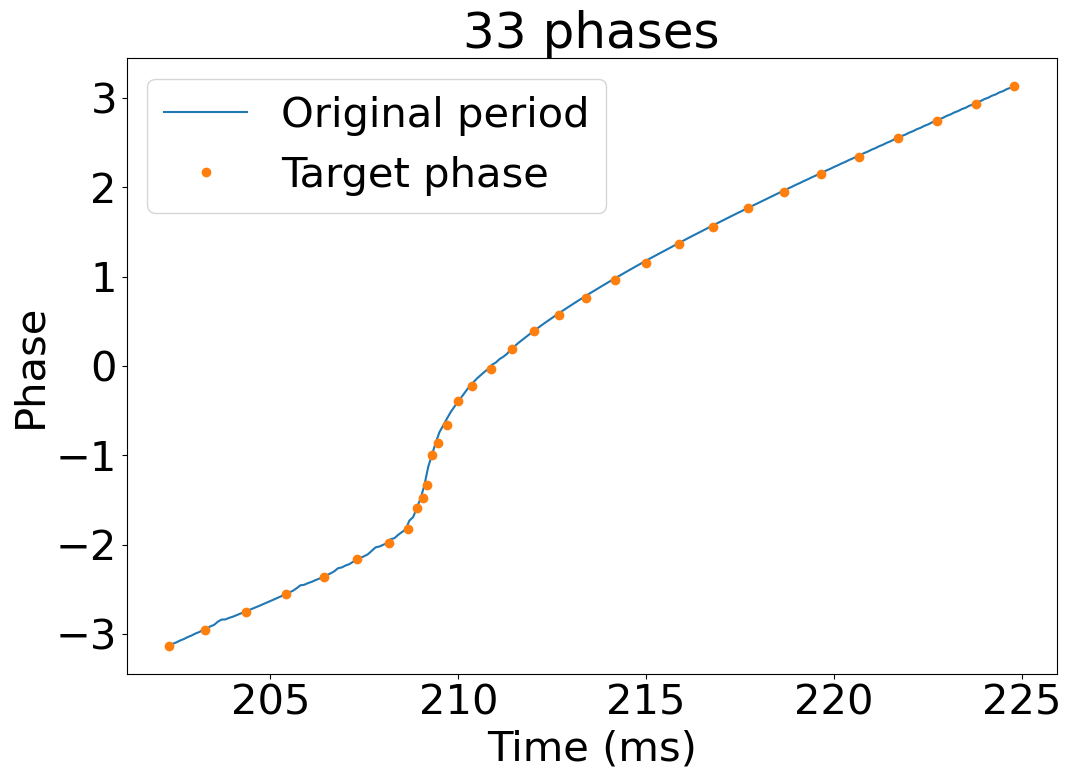

In [12]:
from scipy.interpolate import interp1d
# obtain the corresponding time of the 33 phases
time = t[T_pre_ind+start_index:T_pre_ind+end_index]  # 时间轴
phase_period = instantaneous_phase[T_pre_ind+start_index:T_pre_ind+end_index]

# 生成平均分布的 33 个相位点
phase_target = np.linspace(-np.pi, np.pi, num_phase)

# 使用插值方法找到这些相位对应的时间
interp_func = interp1d(phase_period, time, kind='linear', fill_value="extrapolate")
time_target = interp_func(phase_target) # the time of the 33 phases after T_pre (ms)

# 把time_target限定在time的范围内
time_target[time_target<=time[0]] = time[0]
time_target[time_target>=time[-1]] = time[-1]
time_target_ind = (time_target/dt).astype(int) #这里的time_target应该是近似的，所以有可能超过实际的周期时间
# time_target_ind_after_T_pre = time_target_ind - T_pre_ind

plt.figure(figsize=(12, 8))
plt.plot(time, phase_period, '-', label='Original period')
plt.plot(time_target, instantaneous_phase[time_target_ind], 'o', label='Target phase')
plt.xlabel('Time (ms)')
plt.ylabel('Phase')
plt.legend()
plt.title('33 phases')

In [13]:
#simulation: get the reaction time for different phases

#store the reaction time for different phases
reaction_times = []
Input_go_rec = []
Out_go_rec = []
Out_nogo_rec = []

T_pre_origin = T_pre
T_after_origin = T_after
for T_phase in time_target-T_pre_origin:
    T_pre = T_phase
    T_after = T_after_origin-T_phase # length of time after sti (ms) for the 2nd simulation
    # T = T_pre+T_sti+T_after # length of Period time (ms）
    T = T_pre+T_sti+T_after

    Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
    Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
    Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
    Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo

    Input_go_rec.append(Input_go.tolist())

    # bias current
    bias = torch.zeros_like(Input_go)
    bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
    bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)
 
    #将模型及相应属性移动到GPU
    device = torch.device('cuda:0')
    LRSNN = LRSNN.to(device)
    Input_go = Input_go.to(device)
    Input_nogo = Input_nogo.to(device)
    bias = bias.to(device)

    # Note: initial values has been loaded
    # Start Simulation
    Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go,_,_ = LRSNN(dt,Input_go+bias)
    Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo,_,_ = LRSNN(dt,Input_nogo+bias)

    Out_go_rec.append(Out_go.cpu().tolist())
    Out_nogo_rec.append(Out_nogo.cpu().tolist())

    # g_go_EE = g_go[1]
    # g_nogo_EE = g_nogo[1]

    # # define the reaction time as performance
    # # reaction time: 从施加刺激开始到输出不为0的时间（或者到go输出大于nogo输出的时间）
    # # calculate the time when the output of go exceed the output of nogo
    # difference = Out_go - Out_nogo
    # exceed_time = torch.nonzero(difference.squeeze()>0)[0].item()*dt
    # reaction_time = exceed_time-T_pre
    # reaction_times.append(reaction_time)
    # print('Phase: ', phases_eff[phases_eff_times==T_phase])
    # print('Reaction Time: ', reaction_time, 'ms')

    # # 处理绘图用的数据以使其能够在cpu上运行
    # Out_go = Out_go.cpu().numpy()
    # Out_nogo = Out_nogo.cpu().numpy()
    # Input_go = Input_go.cpu().numpy()
    # Input_nogo = Input_nogo.cpu().numpy()
    # g_go = [g.cpu().numpy() for g in g_go]
    # g_nogo = [g.cpu().numpy() for g in g_nogo]

    # # Draw Output
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
    # Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)
    # # save the figure
    # fig.savefig('./data_figs/Output_phase_'+str(T_phase)+'.png')
    
    # tag = ['g\_all','g\_EE','g\_EI','g\_IE','g\_II']
    # colors = ['#800080','#FF0000','#009999','#FFA500','#1C63A9']

    # # y_lim = [0,1.5]
    # y_lim = [0,0.1]
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Average Synaptic Conductance for Go")
    # # save the figure
    # fig.savefig('./data_figs/con_go_phase_'+str(T_phase)+'.png')
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Conductance(ax,g_nogo,colors,tag,dt,Input_nogo,ylim=y_lim,title="Average Synaptic Conductance for NoGo")
    # # save the figure
    # fig.savefig('./data_figs/con_nogo_phase_'+str(T_phase)+'.png')

    # # Raster Plot
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
    # # save the figure
    # fig.savefig('./data_figs/rp_go_phase_'+str(T_phase)+'.png')
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
    # # save the figure
    # fig.savefig('./data_figs/rp_nogo_phase_'+str(T_phase)+'.png')

T_pre = T_pre_origin
T_after = T_after_origin

Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values


KeyboardInterrupt: 

In [ ]:
Input_go_rec = np.array(Input_go_rec)
Out_go_rec = np.array(Out_go_rec)
Out_nogo_rec = np.array(Out_nogo_rec)

# save the data
import datetime
now = datetime.datetime.now()
# create a folder to store the data, name=now
import os
folder = f'./data_phase_sensitivity/{now.strftime("%y%m%d%H%M%S")}'
os.makedirs(folder)
np.save(folder+'/Input_go_rec'+'.npy', Input_go_rec)
np.save(folder+'/Out_go_rec'+'.npy', Out_go_rec)
np.save(folder+'/Out_nogo_rec'+'.npy', Out_nogo_rec)
np.save(folder+'/phases_eff'+'.npy', phases_eff)




In [ ]:
# import csv
# import datetime
# now = datetime.datetime.now()
# filename = './data_phase_to_reaction_times/reaction_times_'+now.strftime('%y%m%d%H%M%S')+'.csv'
# with open(filename, mode='w') as file:
#     writer = csv.writer(file)
#     for i in range(len(phases_eff)):
#         writer.writerow([phases_eff[i], reaction_times[i]])

画结果图

In [6]:
def reaction_time_amplitude(phases_eff, Out_go_rec, Input_go_rec, dt):
    interval_sti_peak_go = []
    peak_go_values = []

    for i in range(len(phases_eff)):
        go_signal_energy = Out_go_rec[i].squeeze()**2
        # nogo_signal_energy = Out_nogo_rec[i].squeeze()**2
        Input_go = Input_go_rec[i]
        # Input_nogo = Input_go_rec[i]
        # calculate the time when the output rich the peak
        peak_time_go = np.argmax(go_signal_energy)*dt
        peak_value_go = np.max(go_signal_energy)
        sti_start_time = np.nonzero(Input_go[0])[0][0]*dt
        sti_end_time = np.nonzero(Input_go[0])[0][-1]*dt
        interval_sti_peak_go.append(peak_time_go - sti_start_time)
        peak_go_values.append(peak_value_go)
    return interval_sti_peak_go, peak_go_values

# 读取数据

interval_rec = []
peak_rec = []
phases_eff_rec = []
dt = 0.1
# folder = '/mnt/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/data_phase_sensitivity/241202154338/'

for folder in os.listdir('/mnt/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/data_phase_sensitivity/'):
    # print(folder)
    path_folder = os.path.join('/mnt/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/data_phase_sensitivity/', folder)
    # print(path)
    if os.path.isdir(path_folder):
        for file in os.listdir(path_folder):
            path = os.path.join(path_folder, file)
            # print(path)
            if file == 'Input_go_rec.npy':
                Input_go_rec = np.load(path)
            elif file == 'Out_go_rec.npy':
                Out_go_rec = np.load(path)
            # elif file == 'Out_nogo_rec.npy':
            #     Out_nogo_rec = np.load(path)
            elif file == 'phases.npy':
                phases = np.load(path)
        interval_sti_peak_go, peak_go_values = reaction_time_amplitude(phases, Out_go_rec, Input_go_rec, dt)
        interval_rec.append(interval_sti_peak_go)
        peak_rec.append(peak_go_values)
        phases_eff_rec.append(phases)



In [9]:
interval_rec = np.array(interval_rec)
peak_rec = np.array(peak_rec)
phases_eff_rec = np.array(phases_eff_rec)

# calculate the mean and std of the reaction time for different phases
mean_interval = np.mean(interval_rec, axis=0)
std_interval = np.std(interval_rec, axis=0)
mean_peak = np.mean(peak_rec, axis=0)
std_peak = np.std(peak_rec, axis=0)
phases_eff = np.linspace(-np.pi, np.pi, num_phase)

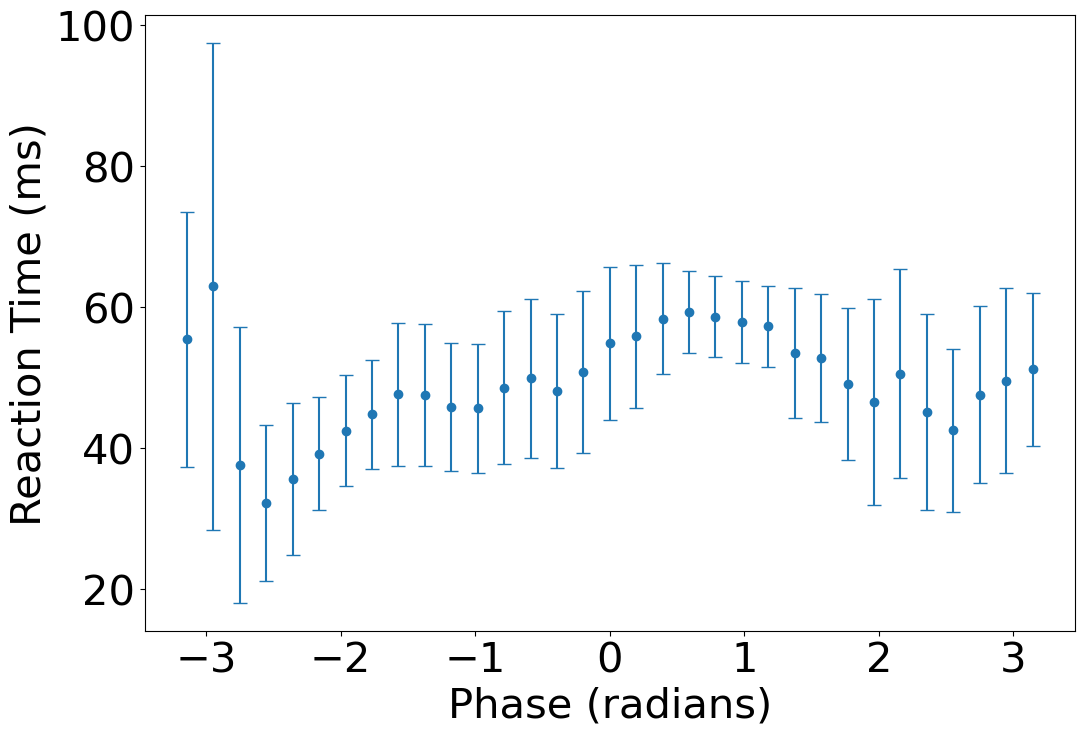

In [10]:
# plot the mean and std of reaction time for different phases
plt.figure(figsize=(12, 8))
plt.errorbar(phases_eff, mean_interval, yerr=std_interval, fmt='o', capsize=5)
plt.xlabel('Phase (radians)')
plt.ylabel('Reaction Time (ms)')
# plt.title('Reaction Time vs. Phase')
plt.show()

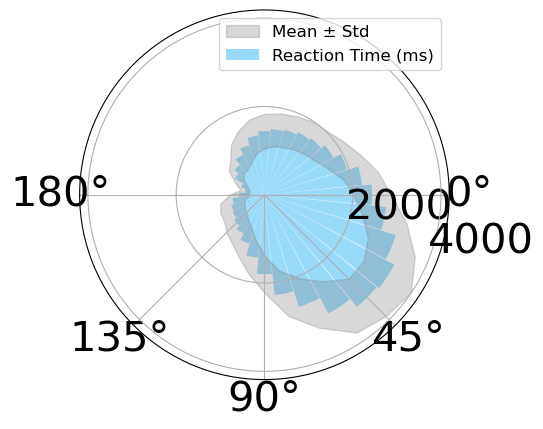

In [11]:
import numpy as np
import matplotlib.pyplot as plt


ax = plt.subplot(111, projection='polar')
# ax.plot(theta, r)
# 顺时针
ax.set_theta_direction(-1)

# labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
# ax.set_xticklabels(labels)

# 设置极坐标角度范围（单位是度）
ax.set_thetamin(-180)  # -π
ax.set_thetamax(180)   #  π

# 绘制柱状图
ax.bar(
    phases_eff[:-1], mean_peak[:-1], width=2*np.pi/33,  # 角度对应位置，半径对应高度，宽度
    color='#32B6F7',  # 颜色
    align='center',  # 从指定的径向位置开始绘制
    bottom=0,  # 远离圆心，设置偏离距离
    alpha=0.5,
    label='Reaction Time (ms)'
)

# ax.plot(phases_eff, mean_peak, label='Mean', color='blue', lw=2)
ax.fill_between(phases_eff,mean_peak - std_peak, mean_peak+ std_peak, color='gray', alpha=0.3, label='Mean ± Std')
# ax.yaxis.set_visible(False)
# ax.text(np.pi * 3 / 2 - 0.2, 90, 'Peak Energy', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

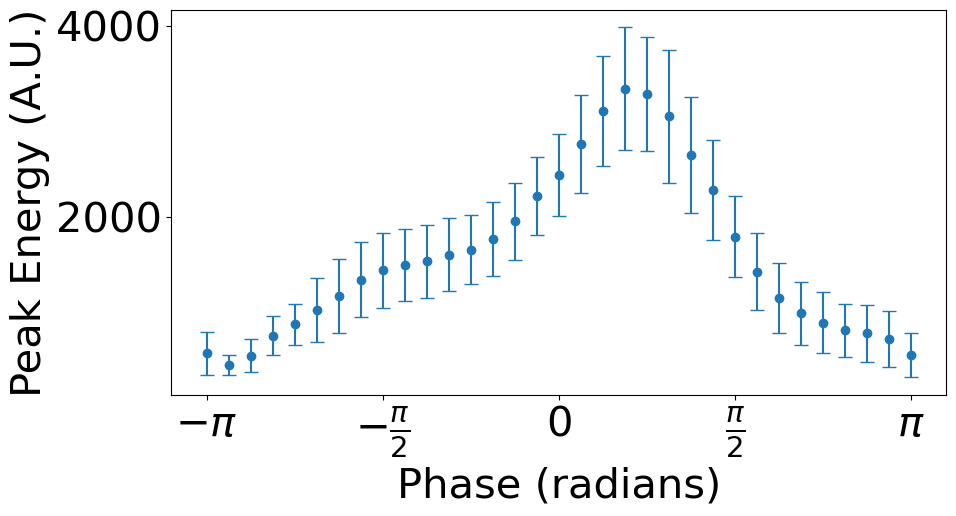

In [12]:
# plot the mean and std of peak value for different phases
plt.figure(figsize=(10, 5))
plt.errorbar(phases_eff, mean_peak, yerr=std_peak, fmt='o', capsize=5)
plt.xlabel('Phase (radians)')
plt.ylabel('Peak Energy (A.U.)')
# plt.title('Dependency of Peak Output Energy on Gamma Oscillation Phase')
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
labels = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

plt.xticks(ticks, labels)
plt.show()

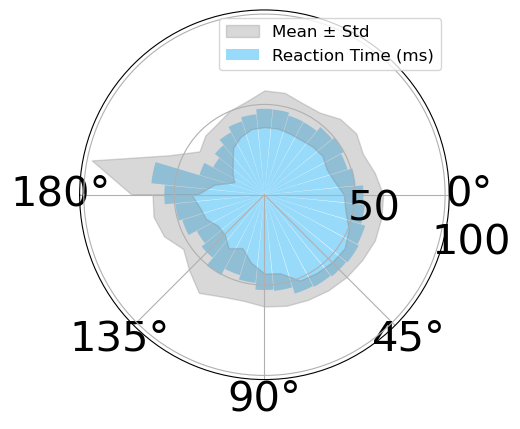

In [13]:
import numpy as np
import matplotlib.pyplot as plt


ax = plt.subplot(111, projection='polar')
# ax.plot(theta, r)
# 顺时针
ax.set_theta_direction(-1)

# labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
# ax.set_xticklabels(labels)

# 设置极坐标角度范围（单位是度）
ax.set_thetamin(-180)  # -π
ax.set_thetamax(180)   #  π

# 绘制柱状图
ax.bar(
    phases_eff[:-1], mean_interval[:-1], width=2*np.pi/33,  # 角度对应位置，半径对应高度，宽度
    color='#32B6F7',  # 颜色
    align='center',  # 从指定的径向位置开始绘制
    bottom=0,  # 远离圆心，设置偏离距离
    alpha=0.5,
    label='Reaction Time (ms)'
)

# ax.plot(phases_eff, mean_peak, label='Mean', color='blue', lw=2)
ax.fill_between(phases_eff,mean_interval - std_interval, mean_interval+ std_interval, color='gray', alpha=0.3, label='Mean ± Std')
# ax.yaxis.set_visible(False)
# ax.text(np.pi * 3 / 2 - 0.2, 90, 'Peak Energy', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

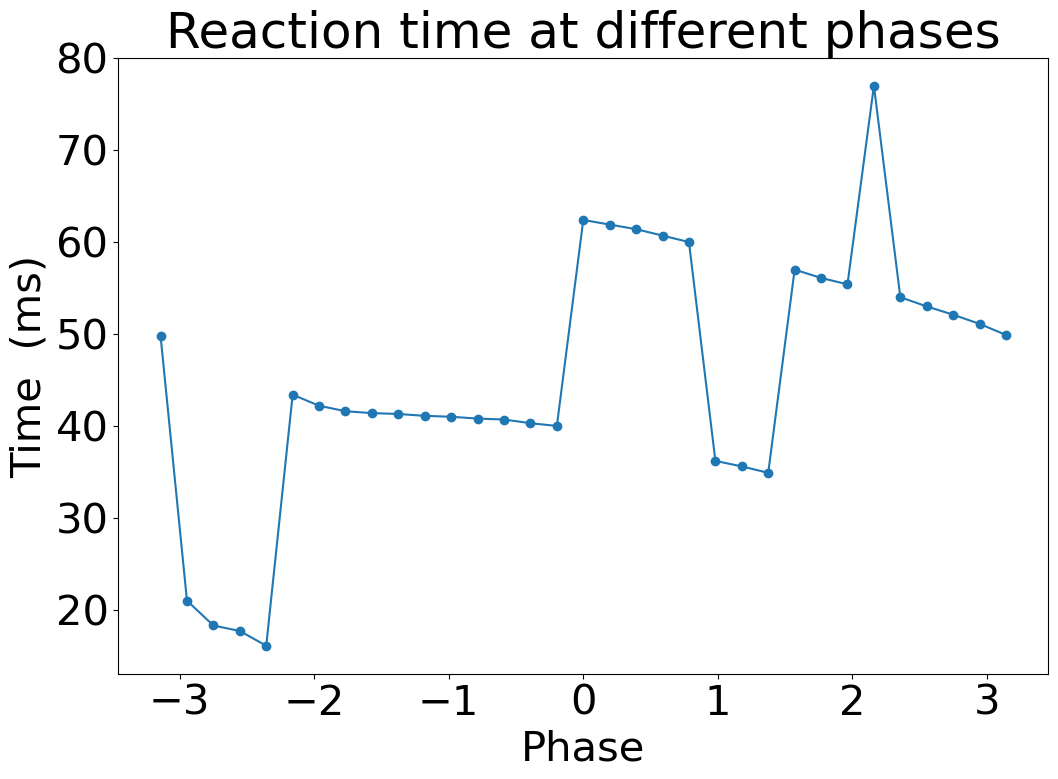

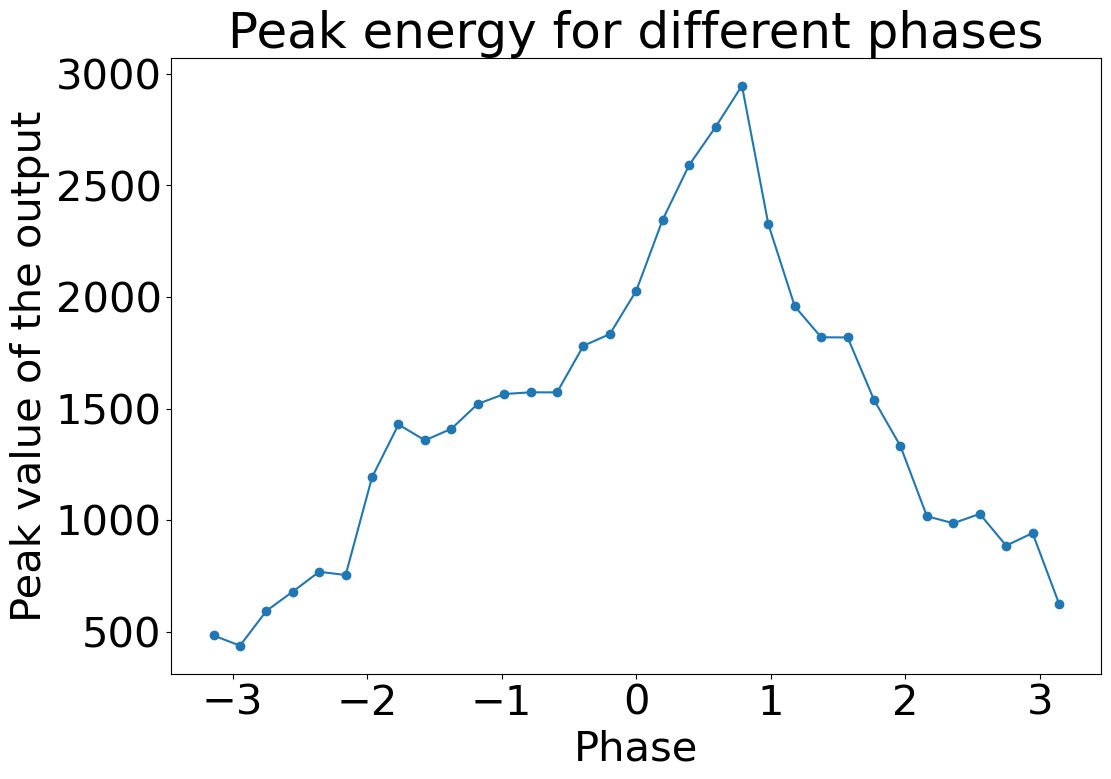

In [14]:


# draw the figure
plt.figure(figsize=(12, 8))
plt.plot(phases_eff, interval_sti_peak_go, 'o-')
plt.xlabel('Phase')
plt.ylabel('Time  (ms)')
plt.title('Reaction time at different phases')#'Time interval between stimulus and peak for different phases'
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(phases_eff, peak_go_values, 'o-')
plt.xlabel('Phase')
plt.ylabel('Peak value of the output')
plt.title('Peak energy for different phases')
plt.show()


In [17]:
# save the phases_eff, std_interval, std_peak, mean_interval, mean_peak seperately as csv file (file name is the same as their own names)
import csv
import datetime
now = datetime.datetime.now()
folder = f'./data_phase_sensitivity'
# os.makedirs(folder)
filename = folder+'/phases_eff.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(phases_eff)
filename = folder+'/std_interval.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(std_interval)
filename = folder+'/std_peak.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(std_peak)
filename = folder+'/mean_interval.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(mean_interval)
filename = folder+'/mean_peak.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(mean_peak)




In [15]:

def peak_envelope(signal, time):
    from scipy.signal import find_peaks
    from scipy.interpolate import interp1d
    # 1. 检测峰值
    peaks, _ = find_peaks(signal, distance=15/dt)
    
    # 2. 获取峰值点的时间和幅度
    peak_times = time[peaks]
    peak_values = signal[peaks]
    
    # 3. 插值生成包络线
    interpolation = interp1d(peak_times, peak_values, kind='cubic', fill_value="extrapolate")
    envelope = interpolation(time)

    return peaks, peak_times, peak_values, envelope

i = 0
go_signal = Out_go_rec[i].squeeze()
nogo_signal = Out_nogo_rec[i].squeeze()
Input_go = Input_go_rec[i]
Input_nogo = Input_go_rec[i]

# 绘制 Go 和 Nogo 信号的包络线
time = np.array(range(len(Input_go[0])))*dt # 时间轴
peak_indx_go, peak_times_go, peak_values_go, env_go = peak_envelope(go_signal**2, time)
peak_indx_nogo, peak_times_nogo, peak_values_nogo, env_nogo = peak_envelope(nogo_signal**2,time)

# def plot_peak_envelope(time, signal, peak_indx, envelope, peak_times, peak_values, label):
#     plt.figure(figsize=(10, 5))
#     plt.plot(time, signal, label='Original Signal', alpha=0.7)
#     plt.plot(time[peak_indx[0]:], envelope[peak_indx[0]:], label='Envelope (Peaks)', color='red', linewidth=2)
#     plt.scatter(peak_times, peak_values, color='orange', label='Peaks')  # 标出峰值点
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Read Out')
#     plt.title(f'Envelope of {label} (Peak Detection)')
#     # plt.legend()
#     plt.grid()
#     plt.show()

def plot_peak_envelope(ax, time, signal, peak_indx, envelope, peak_times, peak_values, label, input_data, ylim=None):
    """
    在指定的ax对象上绘制信号的包络图。
    
    参数:
        ax (matplotlib.axes.Axes): 用于绘图的轴对象。
        time (array-like): 时间数组。
        signal (array-like): 原始信号数据。
        peak_indx (array-like): 峰值的索引范围。
        envelope (array-like): 包络信号数据。
        peak_times (array-like): 峰值时间点。
        peak_values (array-like): 峰值值。
        label (str): 图表标题中信号的标签。
    """
    ax.plot(time, signal, label='Original Signal', alpha=0.7)
    ax.plot(time[peak_indx[0]:], envelope[peak_indx[0]:], label='Envelope (Peaks)', color='red', linewidth=2)
    ax.scatter(peak_times, peak_values, color='orange', label='Peaks')  # 标出峰值点
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Read Out')
    ax.set_title(f'Envelope of {label} (Peak Detection)')
    ax.grid()
    if ylim:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([np.min([0,np.min(envelope),ax.get_ylim()[0]]), np.max([0.0000001,np.max(envelope),ax.get_ylim()[1]])])
    ax.fill_between(time, ax.get_ylim()[0], ax.get_ylim()[1], where=input_data[0].squeeze()!=0, color='gray', alpha=0.2)
    ax.legend(loc = 1, prop={'size':10})

# 绘制 Go 和 Nogo 信号的包络线
fig, ax = plt.subplots(figsize=(10,5))
plot_peak_envelope(ax,time, go_signal**2, peak_indx_go, env_go, peak_times_go, peak_values_go, 'Go', Input_go)
# ax.legend(fontsize=15)
ylim = ax.get_ylim()
fig, ax = plt.subplots(figsize=(10,5))
plot_peak_envelope(ax,time, nogo_signal**2, peak_indx_nogo, env_nogo, peak_times_nogo, peak_values_nogo, 'Nogo', Input_nogo, ylim=ylim)
# ax.legend(fontsize=15)

    





NameError: name 'Out_nogo_rec' is not defined

In [ ]:
# plot the reaction time for different phases using the csv file in ./data_phase_to_reaction_times
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# phases = []
phases = 2*np.pi*np.linspace(0, 1, num_phase)-np.pi
reaction_times = []
folder_path = './data_phase_to_reaction_times/'
# folder_path = Path('./data_phase_to_reaction_times/')

for file in Path('./data_phase_to_reaction_times/').iterdir():
    print(file.name)
    phases_temp = []
    reaction_times_temp = []
    with open(folder_path+file.name, mode='r') as f:
        reader = csv.reader(f)
        for row in reader:
            phases_temp.append(float(row[0]))
            reaction_times_temp.append(float(row[1]))
    reaction_times.append(reaction_times_temp)
    # plt.figure(figsize=(15, 5))
    # plt.plot(phases_temp, reaction_times_temp, label=file.name)
    # plt.xlabel('Phase')
    # plt.ylabel('Reaction Time [ms]')
    # plt.title('Reaction Time for Different Phases')
    # plt.legend()
    # plt.show()




In [ ]:
# # Average and std of the reaction times for different phases
# reaction_times = np.array(reaction_times)
# reaction_times_mean = np.mean(reaction_times, axis=0)
# reaction_times_std = np.std(reaction_times, axis=0)

# # plot the average reaction time for different phases
# plt.figure(figsize=(15, 5))
# plt.errorbar(phases, reaction_times_mean, yerr=reaction_times_std, fmt='o')
# # set the xticks in the unit of pi
# plt.xticks(np.arange(-np.pi, np.pi+0.1, np.pi/2),['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
# plt.xlabel('Phase')
# plt.ylabel('Reaction Time [ms]')
# plt.title('Average Reaction Time for Different Phases')
# plt.show()

